<a href="https://colab.research.google.com/github/Danpollak/Word2Note/blob/master/CharacterLevel%20-%20Seq2Seq%20With%20Embbedings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import tensorflow
import pickle as pk
from tqdm.notebook import tqdm
import statistics

import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Embedding, Input, Concatenate
from tensorflow import keras

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Dataset Notebook:
https://colab.research.google.com/drive/1lo3Xhqab9X4m8VNxcTWCcWTwViXeiBte

Midi Generator Notebook:
https://colab.research.google.com/drive/12-FrSMQSbhGYpHszJGVXBYdZRw3RwKkR

Letters to Note

Spaces Were Tagged with "BREAK"

We tried to use the entire dataset for training but the network converged to a SOS EOS situation propably due to extensive buffering of the EOS tag, as a result we tried to use a subset of the dataset with the length being around the median with a deviation of -2

Resulted in SOS BREAK BREAK BREAK....

Giving GT as intial input resulted in replication of Note

Could be because there a high chance of reptiations of the same note in consecutive letters

Playing with batch size from 4-128 didnt help

Playing with number of epochs 1-20 didnt help

## Data

In [ ]:
class NoteLang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"unk": 0, "SOS": 1, "EOS": 2}
        self.index2word = {0: "unk", 1: "SOS", 2: "EOS"}
        self.note2index = {"unk": 0, "SOS": 1, "EOS": 2}
        self.index2note = {0: "unk", 1: "SOS", 2: "EOS"}
        self.n_words = 3
        self.n_notes = 3

    def addSentence(self, sentence):
        for subword in sentence:
            self.addWord(subword)

    def addWord(self, word):
      subword = word[0]
      note = word[1]

      # insert subwords
      if subword not in self.word2index:
          self.word2index[subword] = self.n_words
          self.index2word[self.n_words] = subword
          self.n_words += 1

      # insert notes
      if note not in self.note2index:
          self.note2index[note] = self.n_notes
          self.index2note[self.n_notes] = note
          self.n_notes += 1

    def check_unk(self, subword, vocabulary):
        if subword in vocabulary:
          return vocabulary[subword]
        else:
          return vocabulary["unk"]

    def sentence2index(self,sentence):
      indexed_sentence = [self.check_unk(subword, self.word2index) for subword in sentence]
      return indexed_sentence

    def note_sentence2index(self,sentence):
      indexed_sentence = [self.check_unk(note, self.note2index) for note in sentence]
      return indexed_sentence

def order_dataset(dataset, max_line_length, train=True):
    features = []
    labels = []
    line_length = 0

    for song in tqdm(dataset):
      line = song[0]
      line_features  = []
      line_label =[]

      line_to_parse = [('SOS', 'SOS')]
      line_to_parse.extend(line)
      line_to_parse.append(('EOS', 'EOS'))

      for subword in line_to_parse:
        line_length+=1
        letter = subword[0]
        line_features.append(letter)
        note = subword[1]
        line_label.append(note)

      # append whole line to dataset
      features.append(line_features)
      labels.append(line_label)

      if train:
        # get max line length
        max_line_length = max(max_line_length, line_length)
        line_length=0
        NoteVocab.addSentence(line_to_parse)

    # encode features and labels
    features = [NoteVocab.sentence2index(line) for line in tqdm(features)]
    labels = [NoteVocab.note_sentence2index(line) for line in tqdm(labels)]

    # buffer features and labels
    features = [np.pad(line, (0,max_line_length - len(line)), constant_values=2) for line in tqdm(features)]
    labels = [np.pad(line, (0,max_line_length - len(line)), constant_values=2) for line in tqdm(labels)]

    # convert to numpy
    features = np.array(features)
    labels = np.array(labels)

    print("printing shapes for sainty check:")
    print(features.shape)
    print(labels.shape)

    print("printing parsed data for sainty check:")
    print(features[0])
    print(labels[0])

    print("Max Line is:")
    print(max_line_length)

    return features, labels, max_line_length

def filter_dataset(ds):
    train_set = ds['train']
    test_set = ds['test']
    
    print("Length Before Filtering is:")
    print("Train: " + str(len(train_set)))
    print("Test: " + str(len(test_set)))

    median = statistics.median([len(song[0]) for song in train_set])
    print("Median Length is: " + str(median))

    train_set = [song for song in train_set if len(song[0]) < median and len(song[0]) > (median - 2)]
    test_set = [song for song in test_set if len(song[0]) < median and len(song[0]) > (median - 2)]

    print("Length After Filtering is:")
    print("Train: " + str(len(train_set)))
    print("Test: " + str(len(test_set)))

    return train_set, test_set

## Import Data

In [ ]:
#data_path = '/content/dali_characters_split.pickle'

from google.colab import drive
drive.mount('/content/drive')
data_path= '/content/drive/My Drive/Colab Notebooks/DALI/dcs.pickle'
NoteVocab = NoteLang('word2note')
max_line_length = 0

with open(data_path, 'rb') as pickle_file:
    ds = pk.load(pickle_file)

train_set, test_set = filter_dataset(ds)

features, labels, max_line_length = order_dataset(train_set, max_line_length)
features_test, labels_test, _ = order_dataset(test_set, max_line_length, False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Length Before Filtering is:
Train: 170725
Test: 42681
Median Length is: 23
Length After Filtering is:
Train: 7044
Test: 1792



printing shapes for sainty check:
(7044, 24)
(7044, 24)
printing parsed data for sainty check:
[ 1  3  4  5  6  7  8  9  5  9  7 10 11  5  6  8 12 12  8  5 13  3  5  2]
[ 1  3  4  5  6  7  7  7  5  3  4  4  4  5  6  7  7  8  9  5 10 11  5  2]
Max Line is:
24



printing shapes for sainty check:
(1792, 24)
(1792, 24)
printing parsed data for sainty check:
[ 1  6  7 10 12  5  9  7 10 13  4 10  8 26  5 14 17  5 20  3 12 10  5  2]
[ 1 14 15 15 15  5 36 37 37 37 37 37 37 37  5 54 55  5 76 77 77 77  5  2]
Max Line is:
24


## Models

Assume the Data is of the form Lyrics $\to $ Line $\to$ Word $\to$ Note (in Hz) and Time Delta

3 Levels of accuracy: lyrics level, line level, word level

Total Word length, add it to loss if delta exceeds

Other loss MSE HZ wise

## Sentence2Note LSTM

In [ ]:
# Hyperparameters
vocab_size = NoteVocab.n_words
number_of_notes = NoteVocab.n_notes
word_embedding_size = 50
LSTM_embedding_size = 50

Model: "Note_Seq2Seq"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Note_Encoder_Inputs_Word (Input [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
Note_Decoder_Inputs_Word (Input [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
Note_Encoder (LSTM)             [(None, 50), (None,  10400       Note_Encoder_Inputs_Word[0][0]   
__________________________________________________________________________________________________
Note_Decoder (LSTM)             [(None, 24, 50), (No 10400       Note_Decoder_Inputs_Word[0][0]   
                                                                 Note_Encoder[0][1]    

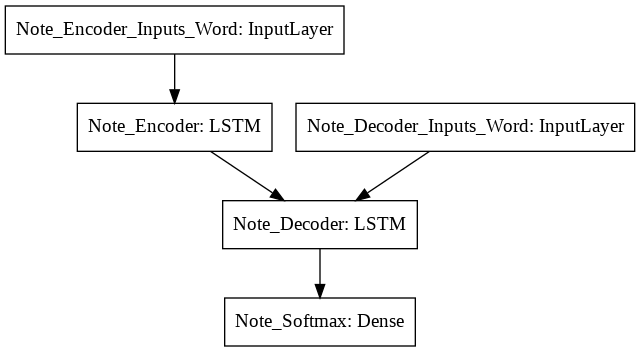

In [ ]:
# define note architecture
note_encoder_inputs_word = Input(shape=(max_line_length,1), dtype='float32', name="Note_Encoder_Inputs_Word")
note_decoder_inputs_word = Input(shape=(max_line_length,1), dtype='float32', name="Note_Decoder_Inputs_Word")

# defining LSTM Encoder
note_encoder_LSTM = LSTM(LSTM_embedding_size, return_state=True, name="Note_Encoder")
# getting LSTM Encoder output
_, note_state_h, note_state_c = note_encoder_LSTM(note_encoder_inputs_word)
note_encoder_states = [note_state_h, note_state_c]

# defining LSTM Decoder
note_decoder_LSTM = LSTM(LSTM_embedding_size, return_state=True, return_sequences=True, name="Note_Decoder")
# getting LSTM Decoder output
note_decoder_outputs, _, _ = note_decoder_LSTM(note_decoder_inputs_word, initial_state=note_encoder_states)

# note softmax
note_decoder_dense = Dense(number_of_notes, activation='softmax', name="Note_Softmax")
note_decoder_outputs = note_decoder_dense(note_decoder_outputs)

# model definition for training
model = Model([note_encoder_inputs_word  ,note_decoder_inputs_word], note_decoder_outputs,name="Note_Seq2Seq")

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy') 
          
model.summary()
keras.utils.plot_model(model, expand_nested=True)

## Training

In [ ]:
checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=1, verbose=0, mode='min',
    baseline=None, restore_best_weights=False
)

In [ ]:
%%time
train_metadata = model.fit([features, labels], labels,
          batch_size=4,
          epochs=20,
          validation_split=0.3,
          callbacks=[model_checkpoint_callback, early_stop_callback],
          )
history = train_metadata.history

Epoch 1/20
1233/1233 [==============================] - 9s 8ms/step - loss: 2.2650 - val_loss: 1.6209
Epoch 2/20
1233/1233 [==============================] - 9s 7ms/step - loss: 1.4621 - val_loss: 1.2617
Epoch 3/20
1233/1233 [==============================] - 9s 7ms/step - loss: 1.1852 - val_loss: 1.0705
Epoch 4/20
1233/1233 [==============================] - 9s 7ms/step - loss: 1.0152 - val_loss: 0.9332
Epoch 5/20
1233/1233 [==============================] - 9s 7ms/step - loss: 0.8937 - val_loss: 0.8317
Epoch 6/20
1233/1233 [==============================] - 9s 7ms/step - loss: 0.7995 - val_loss: 0.7514
Epoch 7/20
1233/1233 [==============================] - 9s 7ms/step - loss: 0.7230 - val_loss: 0.6952
Epoch 8/20
1233/1233 [==============================] - 9s 7ms/step - loss: 0.6630 - val_loss: 0.6363
Epoch 9/20
1233/1233 [==============================] - 9s 7ms/step - loss: 0.6097 - val_loss: 0.5987
Epoch 10/20
1233/1233 [==============================] - 9s 7ms/step - loss: 0.565

## Rebuild Mpdel

In [ ]:
model.load_weights(checkpoint_filepath)

Model: "Note_Seq2Seq_Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Note_Encoder_Inputs_Word (In [(None, 24, 1)]           0         
_________________________________________________________________
Note_Encoder (LSTM)          [(None, 50), (None, 50),  10400     
Total params: 10,400
Trainable params: 10,400
Non-trainable params: 0
_________________________________________________________________


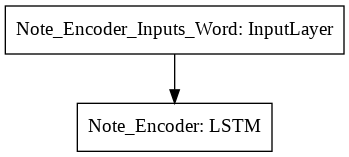

In [ ]:
# Rebuild Encoder
encoder_model = Model(note_encoder_inputs_word, [note_state_h, note_state_c], name="Note_Seq2Seq_Encoder")
encoder_model.summary()
keras.utils.plot_model(encoder_model)

Model: "Note_Seq2Seq_Decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Note_Decoder_Inputs_Word_Eval ( [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
Hidden_State (InputLayer)       [(None, 50)]         0                                            
__________________________________________________________________________________________________
Context_Vector (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
Note_Decoder (LSTM)             multiple             10400       Note_Decoder_Inputs_Word_Eval[0][
                                                                 Hidden_State[0

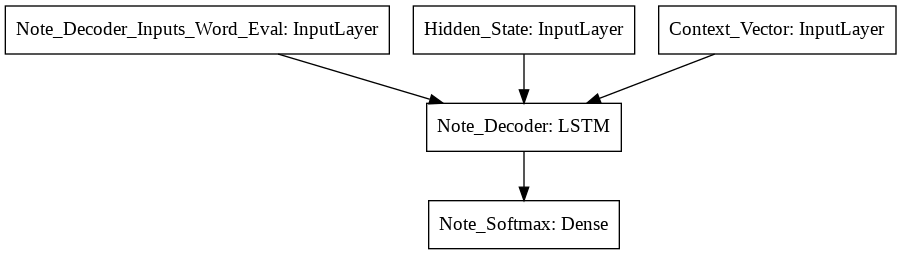

In [ ]:
# Rebuild Decoder
# inputs
note_decoder_inputs_word = Input(shape=(1,1), dtype='float32', name="Note_Decoder_Inputs_Word_Eval")
decoder_state_input_h = Input(shape=(LSTM_embedding_size,), name="Hidden_State")
decoder_state_input_c = Input(shape=(LSTM_embedding_size,), name="Context_Vector")

# embbeding and reordering
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoding
decoder_outputs, state_h, state_c = note_decoder_LSTM(note_decoder_inputs_word, initial_state=decoder_states_inputs)
decoder_outputs = note_decoder_dense(decoder_outputs)

decoder_model = Model(
    [note_decoder_inputs_word, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs, state_h, state_c],
    name="Note_Seq2Seq_Decoder")

decoder_model.summary()

keras.utils.plot_model(decoder_model)

## Inference

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    note_state_h, note_state_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    # 0 is SOS token
    target_seq[0, 0] = NoteVocab.note2index["G4_S"]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq, note_state_h, note_state_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, 0, :])

        sampled_char = NoteVocab.index2note[sampled_token_index]
        decoded_sentence.append(sampled_char)

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == "EOS" or len(decoded_sentence) >= max_line_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        note_state_h = h
        note_state_c = c

    return decoded_sentence

In [ ]:
labels[0]

array([ 1,  3,  4,  5,  6,  7,  7,  7,  5,  3,  4,  4,  4,  5,  6,  7,  7,
        8,  9,  5, 10, 11,  5,  2])

In [ ]:
print(decode_sequence(np.expand_dims(features_test[20], axis=0)))

['G#4_S', 'E4', 'D5_S', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5']
